In [1]:
import xarray as xr
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import pycno

### Get GC Jacobian run output data

In [67]:
with open('../../setup_run_test.sh') as inf:
    lines = inf.read()

In [68]:
for ll in list(filter(None,lines.split('\n'))):
    if 'OutputPath=' in ll:
        break
output_dir = ll.split('\"')[1]

In [69]:
output_dir

'/path/to/imi/output'

In [3]:
#out_dir = '/n/holyscratch01/jacob_lab/jeast/proj/globalinv/testing_monthly/output'
jpath = (
    f'{output_dir}/imi_20180601/jacobian_runs/'
    'imi_20180601_{:06d}/OutputDir'
)

In [5]:
ds_output = dict()
for i in range(4):
    print(f'\r{i}',end='')
    ds_output[i] = xr.open_mfdataset(
        sorted(glob(f'{jpath.format(i)}/output_*.nc')),
        combine='nested', concat_dim='nobs'
    )
    ds_output[i].load();

3

### Get tropomi input obs

In [7]:
output_files = sorted(glob(f'{jpath.format(0)}/output_*.nc'))
input_files = [f.replace('output_','../SatelliteObservations/input_') for f in output_files]

In [9]:
ds_input = xr.open_mfdataset(
    input_files,
    combine='nested', concat_dim='nobs'
)
ds_input.load();

### functions to bin data to 2x2.5 grid

In [11]:
lats = np.arange(-90, 91, 2, dtype=np.float32)
lats[0] = -89.5
lats[-1] = 89.5
lons = np.arange(-180, 180, 2.5, dtype=np.float32)

In [12]:
lonbins = np.hstack((
    lons[0] - 1.25,
    lons[:-1] + np.diff(lons)/2,
    lons[-1] + 1.25
))

In [13]:
latbins = np.hstack((
    -90,
    np.arange(-89,90,2),
    90
))

In [14]:
def mean_xch4(lat, lon, data):
    nsamples, yy, xx = np.histogram2d(
        lat, lon,
        bins=(latbins, lonbins)
    )
    xch4_sum, xx, yy = np.histogram2d(
        lat, lon,
        bins=(latbins, lonbins),
        weights=data
    )
    xch4_avg = xch4_sum / nsamples
    return xch4_avg

### Apply shift to obs lons to properly bin

In [15]:
def shift(inlon):
    return np.where(
        np.mod(np.abs(inlon), 178.75) != np.abs(inlon),
        -181.25 + np.mod(inlon, 178.75),
        inlon
    )

In [16]:
ds_input['longitude'] = xr.apply_ufunc(shift, ds_input.longitude)

In [18]:
ds_output_binned = dict()
for i in range(4):
    ds_output_binned[i] = (
        mean_xch4(
            ds_input.latitude.values,
            ds_input.longitude.values,
            ds_output[i].gc_xch4.values * 1e9
        )
    )

/tmp/ipykernel_1208818/81888709.py:11: RuntimeWarning: invalid value encountered in divide
  xch4_avg = xch4_sum / nsamples


### plot

In [20]:
cno = pycno.cno()

In [46]:
def plot_pert(i_pert):
    fig,axs = plt.subplots(1,3, figsize=(12,3),sharex=True, sharey=True)
    pc = axs[0].pcolormesh(
        lonbins, latbins, 
        ds_output_binned[0],
        vmin=1780, vmax=1950
    )
    fig.colorbar(pc,ax=axs[0],label='XCH4 [ppb]')
    axs[0].set_title('GC XCH4 (base)')

    pc = axs[1].pcolormesh(
        lonbins, latbins, 
        ds_output_binned[i_pert],
        vmin=1780, vmax=1950
    )
    fig.colorbar(pc,ax=axs[1],label='XCH4 [ppb]')
    axs[1].set_title(f'GC XCH4 (pert {i_pert})')

    pc = axs[2].pcolormesh(
        lonbins, latbins, 
        ds_output_binned[i_pert] - ds_output_binned[0],
        vmin=-0.35, vmax=0.35,
        cmap = 'RdBu_r'
    )
    fig.colorbar(pc,ax=axs[2],label='$\Delta$XCH4 [ppb]')
    axs[2].set_title('GC XCH4 ($\Delta$)')

    for ax in axs.ravel():
        #cno.draw(ax=ax)
        ax.set_facecolor('grey')
        ax.set_ylim(-50,80)
    plt.show()

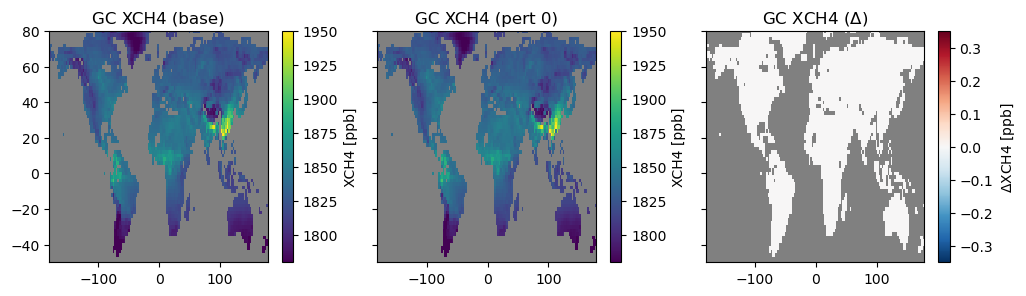

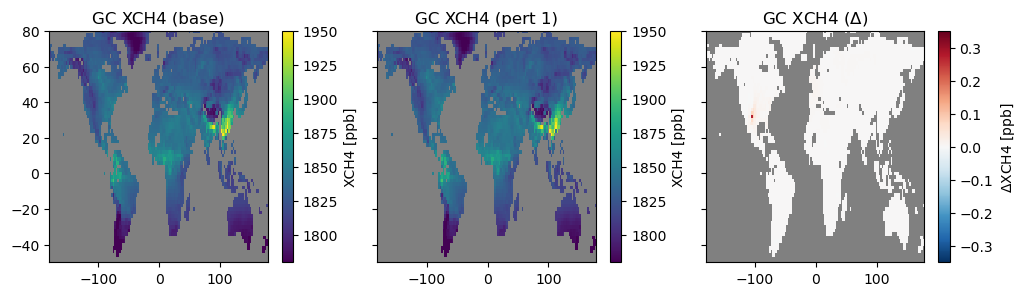

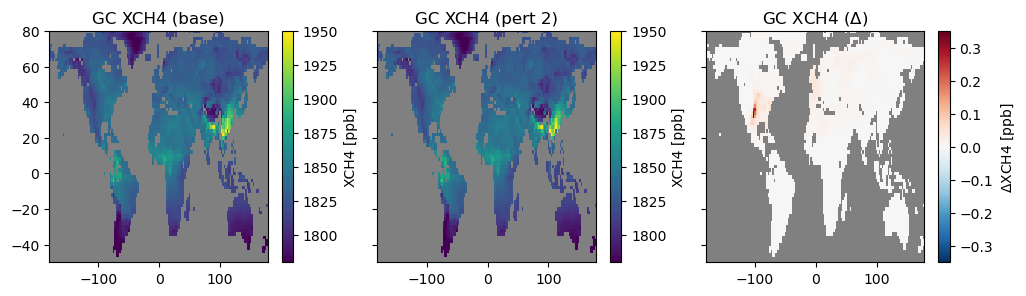

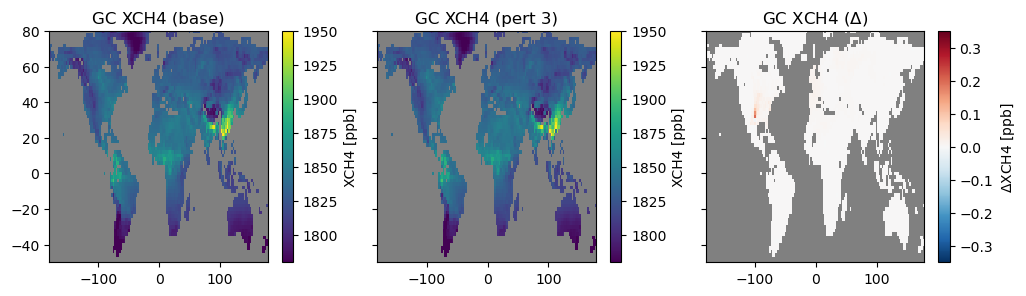

In [47]:
for i in range(4):
    plot_pert(i)